In [0]:
############PROGRAM STARTS HERE ######################
import numpy as np
import math as MT
from math import floor
import matplotlib.pyplot as plt
import time


###CONSTANTS
max_angle = 0.785398 #45Deg
min_angle = -0.785398 #-45Deg
free_space=0
locked_space=1

### HYPER PARAMETERS
NUMBERS_OF_STEERS=4
STEER_OFFSET=5.0*np.pi/180
LENGTH=4.0
NUM_THETA_CELLS =60

### GRID MAKING 
grid_x_m = 40
grid_y_m = 40

### FOR CELL DIVISION
coll_cell_side = 0.5
grid_on_x = np.int( np.ceil(grid_x_m/coll_cell_side) )
grid_on_y = np.int( np.ceil(grid_y_m/coll_cell_side) )

### FIT ZEROS
GRID_TEST = np.zeros((grid_on_x,grid_on_y),np.int)

### INITIALIZE COST_MAPS AND ASTAR CLOSE MAPS
value_map = np.array([[1000 for x in range(grid_on_x)] for y in range(grid_on_y)])

### MOTION MATRIX FOR ASTAR
motion_mat=np.array([[1,0],[-1,0],[0,-1],[0,1]])



In [0]:

### STATE CLASS
class state:
  def __init__(self,x,y,theta,g,f,h,steer):
    self.x=x
    self.y=y
    self.theta=theta
    self.g=g
    self.f=f
    self.h=h
    self.steer=steer
    
 ## GOAL NODE        
class goal:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
### INPUT VEHICLE CO-ORDINATES
class vehicle_points():
  def __init__(self,input_co_ordinates,center):
    self.input_co_ordinates=input_co_ordinates
    self.center=center
    
### PATH CLASS FOR TRACKING   
class path():
  def __init__(self,closed,came_from,final):
    self.closed=closed
    self.came_from=came_from
    self.final=final
    

### AUGMENT DELTA +/- GIVEN OFFSET
def delta_augmentation(delta, numbers, offset):
    delta_list = []
    delta_list.append(delta)
    delta_calc_add=delta_calc_sub = delta
    for i in range(0 ,numbers):
        delta_calc_add += offset
        delta_calc_sub -= offset
        if delta_calc_add < max_angle:
            delta_list.append(delta_calc_add)
        if delta_calc_sub > min_angle:
            delta_list.append(delta_calc_sub)
    return delta_list
  


### NEW STATE TRANSITIONS
def new_state_transition(current_state,goal,speed):
    next_states = []
    delta_angles = delta_augmentation( delta=current_state.steer, numbers=NUMBERS_OF_STEERS,offset=STEER_OFFSET)
    DT=1.0/speed
    for delta in delta_angles:
        omega  = (speed / LENGTH) * np.tan(delta)
        theta2 = normalize_theta(current_state.theta + (omega * DT))
        dX = speed * np.cos(theta2) * DT
        dY = speed * np.sin(theta2) * DT
        x2     = current_state.x + dX
        y2     = current_state.y + dY
        g2     = current_state.g + np.sqrt(dX*dX + dY*dY)
        arc_cost=arc_heuristic(goal.x-x2,goal.y-y2,theta2) 
        h2=value_map[idx(x2)][idx(y2)]+arc_cost
        f2     = g2 + h2
        new_state=state(x2,y2,theta2,g2,f2,h2,delta)
        next_states.append(new_state)
    return next_states

### TRANSFORM VEHICLE CO-ORDINATES 
def transform_vehicle_co_ordinates(vehicle_point_object, next_state, angle_of_rotation):
    displaced_matrix = np.array([next_state[0]-vehicle_point_object.center[0],next_state[1]-vehicle_point_object.center[1]])
    transformed_matrix=np.add(vehicle_point_object.input_co_ordinates,displaced_matrix)
    return vehicle_points(rotate_vehicle_co_ordinates(vehicle_points(transformed_matrix,next_state),angle_of_rotation),next_state)
  
  
### ROTATE VEHICLE CO-ORDINATES     
def rotate_vehicle_co_ordinates(vehicle_point_object,angle_of_rotation):
    rotation_matrix = np.array([[np.cos(angle_of_rotation), np.sin(angle_of_rotation)], 
                                [-np.sin(angle_of_rotation), np.cos(angle_of_rotation)]])
    return np.add(vehicle_point_object.center,np.matmul(np.subtract(vehicle_point_object.input_co_ordinates,vehicle_point_object.center), rotation_matrix))
  
  
### CHECK VEHICLE IN SAFE POSITION  
def is_vehicle_in_safe_position(vehicle_point_object,grid):
  for point in vehicle_point_object.input_co_ordinates:
    if(is_within_grid( idx(point[0]),idx(point[1])) and  
       (grid[idx(point[0])][idx(point[1])]==0)):
      continue
    else:
      return False
  return True

### CHK A STAR VEHICLE:
def A_vehicle_is_safe(vehicle_point_A,add_value,grid):
  vp=vehicle_point_A.input_co_ordinates+add_value
  for point in vp:
    if(is_within_grid( idx(point[0]),idx(point[1])) and  
       (grid[idx(point[0])][idx(point[1])]==0)):
      continue
    else:
      return False
  return True
    
    

### EUCLIDEAN DISTANCE
def euclidean_distance(start_point,end_point):
  return np.round(np.sqrt((end_point[0]-start_point[0])**2 +(end_point[1]-start_point[1])**2),4)

### ARC HEURISTIC
def arc_heuristic(x,y,theta_to_be_taken):
  ang_rad=normalize_theta(np.arctan2(y,x))
  diff=np.pi-abs(abs(theta_to_be_taken-ang_rad)-np.pi)
  return diff
  
### NORMALIZE THETA
def normalize_theta(theta):
  if( theta<0 ):
    theta +=( 2*np.pi )
  elif( theta>2*np.pi ):
    theta %=( 2*np.pi)
  return theta

### THETA TO STACK NUMBER
def theta_to_stack_number(theta):
  new = (theta+2*np.pi)%(2*np.pi)
  stack_number = round(new*NUM_THETA_CELLS/2*np.pi)%NUM_THETA_CELLS
  return int(stack_number)

### FLOOR VALUE
def idx(value):
  return int(MT.floor(value))

### CHECK WITHIN GRID  
def is_within_grid(x,y):
  return (x>=0 and x<grid_on_x and y>=0 and y<grid_on_y)

### IS_GOAL_REACHED
def is_goal_reached(start,goal):
  result=False
  if( idx(start[0]) == idx(goal[0]) and idx(start[1])==idx(goal[1])):
    result=True
  return result

### BUILDS THE COST MAP - Here the current state is the goal
def build_cost_map(current_state,goal,grid):
  expand_grid = [[' ' for x in range(grid_on_x)] for y in range(grid_on_y)]
  expand_grid[current_state.x][current_state.y]='*'
  open_list = []
  is_goal_attained=False
  open_list.append(current_state)
  #IMPORTANT
  value_map[current_state.x][current_state.y]=0
  while(len(open_list)>0):
    old_state=open_list.pop(0)
    node=np.array([old_state.x,old_state.y])
    if(goal.x==old_state.x and goal.y==old_state.y):
      is_goal_attained=True
      print("GOAL IS REACHABLE!")
      
    for move in motion_mat:
      nxt_node=node+move
      if( is_within_grid(nxt_node[0],nxt_node[1])):
        if(grid[nxt_node[0]][nxt_node[1]]==0 and expand_grid[nxt_node[0]][nxt_node[1]]!='*'):
          if(A_vehicle_is_safe(vehicle_point_A,np.array([nxt_node]),grid)):
            g2=old_state.g+1
            new_state=state(nxt_node[0],nxt_node[1],0,g2,0,0,0)
            open_list.append(new_state)
            expand_grid[nxt_node[0]][nxt_node[1]]='*'
            value_map[nxt_node[0]][nxt_node[1]]=g2
  return is_goal_attained
            

### SEARCH ALGORITHM
def Hybrid_A_Star(grid,current_state,goal,vehicle_point_object,speed):
  print("STARTED HYBRID A*")
  start_time = time.time()
  closed = np.array([[[free_space for x in range(grid_on_x)] for y in range(grid_on_y)] for cell in range(NUM_THETA_CELLS)])
  came_from = [[[free_space for x in range(grid_on_x)] for y in range(grid_on_y)] for cell in range(NUM_THETA_CELLS)]
  is_goal_attained=False
  stack_number=theta_to_stack_number(current_state.theta)
  closed[stack_number][idx(current_state.x)][idx(current_state.y)]=1
  came_from[stack_number][idx(current_state.x)][idx(current_state.y)]=current_state
  total_closed=1
  opened=[current_state]
  
  while (len(opened)>0):
    opened.sort(key=lambda state_srt : float(state_srt.f))
    state_now=opened.pop(0)
    #print([state_now.x,state_now.y,state_now.theta*np.pi/180])
    if(is_goal_reached([idx(state_now.x),idx(state_now.y)],[idx(goal.x),idx(goal.y)])):
      is_goal_attained=True
      print('GOAL REACHED BY HYBRID A*')
      ret_path=path(closed,came_from,state_now)
      end_time = time.time()
      print(end_time - start_time)
      return (is_goal_attained,ret_path)
    
    for evry_state in new_state_transition(state_now,goal,speed):
      #print('Before',[evry_state.x,evry_state.y,evry_state.theta*np.pi/180])
      if(not is_within_grid(idx(evry_state.x),idx(evry_state.y))):
        continue
      
      stack_num=theta_to_stack_number(evry_state.theta)
      #print([stack_num,idx(evry_state.x),idx(evry_state.y)])
      if closed[stack_num][idx(evry_state.x)][idx(evry_state.y)]==0 and grid[idx(evry_state.x)][idx(evry_state.y)]==0:
        new_vehicle_point_obj = transform_vehicle_co_ordinates(vehicle_point_object,[evry_state.x,evry_state.y],evry_state.theta)
        #print(new_vehicle_point_obj.input_co_ordinates)
        if(is_vehicle_in_safe_position(new_vehicle_point_obj,grid)):
            opened.append(evry_state)
            closed[stack_num][idx(evry_state.x)][idx(evry_state.y)]=1
            came_from[stack_num][idx(evry_state.x)][idx(evry_state.y)]=state_now
            total_closed+= 1
            #print('After',[evry_state.x,evry_state.y,evry_state.theta*np.pi/180])
            #plt.plot([state_now.x,evry_state.x],[state_now.y,evry_state.y])
      #closed[stack_num][idx(evry_state.x)][idx(evry_state.y)]=1
        #print('-------------')
  print('No Valid path')
  ret_path=path(closed,came_from,evry_state)
  return (is_goal_attained,ret_path)



### RECONSTRUCT PATH
def reconstruct_path(came_from, start, final):
    path                 = [(final)]
    stack                = theta_to_stack_number(final.theta)
    current              = came_from[stack][idx(final.x)][idx(final.y)]
    stack                = theta_to_stack_number(current.theta)
    while [idx(current.x), idx(current.y)] != [idx(start[0]), idx(start[1])] :
        path.append(current)
        current              = came_from[stack][idx(current.x)][idx(current.y)]
        stack                = theta_to_stack_number(current.theta)
    return path


###DISPLAY PATH
def show_path(path, start, goal,vehicle_pt_obj_act):
  X=[start[0]]
  Y=[start[1]]
  Theta=[]
  path.reverse()
  X     += [p.x for p in path]
  Y     += [p.y for p in path]
  Theta+=[p.theta for p in path]
  for i in range(len(X)-1):
    Xj=[]
    Yj=[]
    vehicle_pt_obj_now=transform_vehicle_co_ordinates(vehicle_pt_obj_act,[X[i],Y[i]], Theta[i])
    rev=vehicle_pt_obj_now.input_co_ordinates
    revI=rev[:4]
    revL=rev[4:]
    revF=np.concatenate([revI,revL[::-1]])
    l=np.append(revF,[revF[0]],axis=0)
    for i in l:
      Xj.append(i[0])
      Yj.append(i[1])
    plt.plot(Xj,Yj)
  print([np.round(p.steer*180/np.pi,2) for p in path])
  plt.plot(X,Y, color='black')
  plt.scatter([start[0]], [start[1]], color='blue')
  plt.scatter([goal[0]], [goal[1]], color='red')
  plt.show()
  
### PUT OBSTACLES:
def put_obstacles(X_list,Y_list,grid):
  if(len(X_list)>0):
    for i in  X_list:
      x_XO=[]
      x_YO=[]
      for k in range(i[1],i[2]):
        x_XO.append(i[0])
        x_YO.append(k)
        grid[i[0]][k]=1
      plt.scatter(x_XO,x_YO)
  if(len(Y_list)>0):
    for i in Y_list:
      y_XO=[]
      y_YO=[]
      for k in range(i[1],i[2]):
        y_XO.append(i[0])
        y_YO.append(k)
        grid[k][i[0]]=1
      plt.scatter(y_YO,y_XO)

In [0]:
def search(start,goal_node,present_heading,grid,speed):
  vehicle_pt_obj=transform_vehicle_co_ordinates(vehicle_pt_obj_actual,start,present_heading)
  current_state = state(vehicle_pt_obj.center[0], vehicle_pt_obj.center[1], present_heading, 0.0, 0.0, 0.0,0.0)
  if(build_cost_map(state(goal_node.x,goal_node.y,0,0,0,0,0),goal(start[0],start[1]),grid)):
    process_further,ret_val=Hybrid_A_Star(GRID_TEST,current_state,goal_node,vehicle_pt_obj,speed)
    if(process_further):
      show_path(reconstruct_path(ret_val.came_from,start,ret_val.final),start,[goal_node.x,goal_node.y],vehicle_pt_obj_actual)
    else:
      print("GOAL CANT BE REACHED!!")
  else:
    print("GOAL CANT BE REACHED!!")
  

GOAL IS REACHABLE!
STARTED HYBRID A*
GOAL REACHED BY HYBRID A*
0.358570814133
[-20.0, -40.0, -40.0, -40.0, -40.0, -40.0, -40.0, -40.0, -40.0, -40.0, -40.0, -40.0, -20.0, -5.0, 0.0, 5.0, -15.0, -35.0, -40.0, -20.0, 0.0, 5.0, -15.0, -5.0, 0.0, -10.0, 5.0, -5.0, 0.0, 20.0, 5.0, 5.0, 25.0, 40.0, 40.0, 25.0, 10.0, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.0, -5.0, 5.0, -5.0, 5.0, -5.0, 5.0, -5.0, 5.0, -5.0, 5.0]


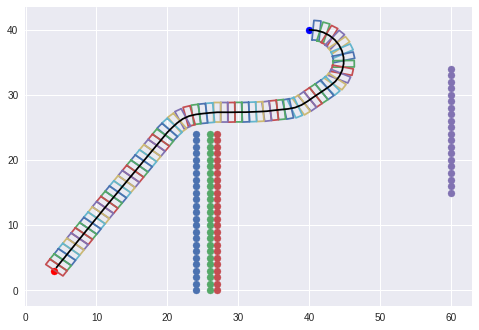

In [0]:
put_obstacles([[24,0,25],[26,0,25],[27,0,25],[60,15,35]],[],GRID_TEST)
### A STAR VEHICLE POINTS
vehicle_point_A=vehicle_points(np.array([[0,2],[0,1],[0,-1],[0,-2],[1,0],[2,0],[-1,0],[-2,0]]),[0,0])
### HYBRID VEHICLE POINTS
vehicle_pt_obj_actual = vehicle_points( np.array([[0.5,0.5],[0.5,1.5],[0.5,2.5],[0.5,3.5],[1.5,0.5],[1.5,1.5],[1.5,2.5],[1.5,3.5]]),[0,2] )

## CALL SEARCH
search([40,40],goal(4,3),0,GRID_TEST,60)